# MULTIGRIS ISM applications
## Predictions (SFGX context)

<font color=red>For best performance, it is advised to execute MULTIGRIS in the shell, as explained in the README. This notebook is just a way to illustrate a workflow. </font>

***
This notebook presents some examples of ISM applications with MULTIGRIS. <font color=red>Make sure to check the general notebooks on how to run the programs beforehand!</font>

We'll also take the occasion to use various plots and inference options. 

The applications will use the following Cloudy grid (Ferland et al. [2017](https://ui.adsabs.harvard.edu/abs/2017RMxAA..53..385F/abstract)):
- SFGX (star-forming galaxies with X-ray component; Ramambason et al. [2022](https://ui.adsabs.harvard.edu/abs/2022A%26A...667A..35R/abstract))

The various notebooks use some specific terms described in the file TERMS.org. 
***

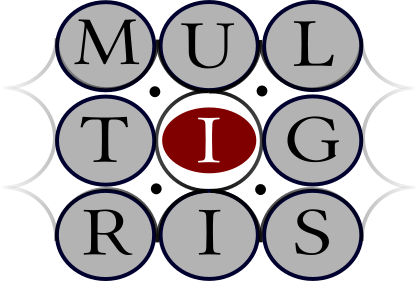

In [1]:
%load_ext autoreload
%autoreload 2
from wand.image import Image as WImage #this is to view PDFs
from IPython.display import Image
Image(filename='../Images/logo.png')

## Table of contents:
* [Post-processing: missing or new observables, secondary parameters...](#app7)
  * [Missing observables and new observables](#app7a)
  * [Secondary parameters](#app7b)

## Imports and settings
***

In [2]:
import os

import sys
sys.path.append('../') 

#arviz to read the PyMC3 trace
import arviz as az

import numpy as np
import matplotlib.pyplot as plt

#imports to make input files
import importlib
import Library.lib_input
importlib.reload(Library.lib_input)
from Library.lib_input import *

#import the main MULTIGRIS scripts
import mgris_search, mgris_process, mgris_post_process, mgris_compare

#may need to run this if the script is interrupted
from Library.lib_main import closelogfiles

# global parameters
from rcparams import rcParams

#to read the grid
import pandas as pd

#this is the input filename we'll use throughout, it will be automatically copied in the output directories each run
os.makedirs('./Runs/ISM_applications', exist_ok=True)
inputfile = './Runs/ISM_applications/input.txt' 

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
if rcParams['inference_backend']=='gpu':
    import jax
    jax.clear_caches()

Checking path in case several copies exist

In [4]:
mgris_search.__file__

'/local/home/vleboute/work/MULTIGRIS/mgris/mgris_search.py'

## Post-processing: missing or new observables, secondary parameters... <a class="anchor" id="app7"></a>
***

In this notebook we've dealt with primary parameters (i.e., those used to uniquely define a model). Once the model is done, it is possible to deduce new tracers like new lines or new, secondary, parameters.

### Missing observables and new observables <a class="anchor" id="app7a"></a>

For observables, the post-processing script automatically infer missing values. Let's test this by simulating one line in the Haro 11 galaxy being invalid. We'll also add a new observable to predict, [OIII] 52um.

Here we use fluxes and uncertainties in log scale. Note that this is not well adapted to lines that are barely detected (a linear scale should be used instead). 

We'll replace the [SIII] 18.7um line flux. The model will only consider HII region lines so we use a single sector for simplicity. 

In [5]:
params = get_params()
params['context'].value = 'Contexts/mgris_sfgx'
output_directory = './Runs/ISM_applications/PP_obs/'
params['output'].value = output_directory
params['USE configuration'].value = '1C1S'
params['select'].value = ['cut [1,1]', 'Z_dust [0,0]'] 
params['BEGIN observations'].value = '''O388.3323m 42.242 0.007 0.007
N357.3238m 41.458 0.012 0.013
N2121.767m 40.552 0.033 0.036
Ne315.5509m 42.088 0.075 0.09
Ne212.8101m 41.548 0.055 0.063
S410.5076m 41.732 0.008 0.008
#S318.7078m 41.738 0.054 0.061
S318.7078m nan
S333.4704m 41.843 0.019 0.019
Ar26.98337m 40.603 0.12 0.167
Ar38.98898m 41.052 0.058 0.067
Ar321.8253m <39.926 nan nan
H112.3684m 40.372 0.074 0.089
N2205.244m 40.376 0.083 0.102'''
#the grid line fluxes are in log [erg s-1] so we could apply a log factor if the unit is not the same
#we add a minimum 10% uncertainty
params['BEGIN observations'].extras = {'scale_factor': 0, 
                                       'delta_add': 0.04, 
                                       'scale': 'log',
                                       'delta_ref': 0.2} #delta_ref is required if we have upper limits in log 
params['use_scaling'].value = "'all'"
params['obs_to_predict'].value = "['O351.8004m']"
make_input(params, inputfile)

In [6]:
if rcParams['inference_backend']=='gpu':
    nsamples_per_job = 150
else:
    nsamples_per_job = 500
    
closelogfiles() #in case run was interrupted
mgris_search.main(args=mgris_search.args(inputfile=inputfile, order=0, nsamples_per_job=nsamples_per_job))







       ┍ M U L ┑
       ┝ T I G ┥
       ┕ R I S ┙






     ┍           ┑
     ┝ INFERENCE ┥
     ┕           ┙






Thanks for using MULTIGRIS.
Please make sure to check the README file, the notebooks, and the publication (https://ui.adsabs.harvard.edu/abs/2022A%26A...667A..34L/abstract).







▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
▓ READING INPUT PARAMETERS ▓
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓


-- Using pre-defined configuration 1C1S

    ┍========================================┑
    ┝========= MULTIGRIS summary ============┥
    ┝========================================┙
    ┝ git version & date:
    ┝ - 1a38371 (2024-09-06 08:20:37 +0200)
    ┝ - 1a38371
    ┝ git submodules:
    ┝ - 'Contexts/mgris_bond': 474a7c3, 'Contexts/mgris_loc': 78805da, 'Contexts/mgris_sfgx': dcd6f15 
    ┝========================================
    ┝ PyMC version  : 5.16.2
    ┝ Tensor library: pytensor
    ┝ - Compile directory:
    ┝   - /tmp/pytensor.NOBACKUP
    ┝ - Precision: float32
    ┕=============

[12  3  8  5  5  8  4  4]
-> [12  1  8  5  5  8  4  4]
[12  1  8  5  5  8  4  4]


n 0: single value (nearest neighbor grid interpolation)


-> [12  1  1  5  5  8  4  4]
[12  1  1  5  5  8  4  4]


u 0: single value (nearest neighbor grid interpolation)


-> [12  1  1  1  5  8  4  4]
[12  1  1  1  5  8  4  4]


Z 0: single value (nearest neighbor grid interpolation)


-> [12  1  1  1  1  8  4  4]
[12  1  1  1  1  8  4  4]


Lx 0: single value (nearest neighbor grid interpolation)


-> [12  1  1  1  1  1  4  4]
[12  1  1  1  1  1  4  4]


Tx 0: single value (nearest neighbor grid interpolation)


-> [12  1  1  1  1  1  1  4]
[12  1  1  1  1  1  1  4]
-> [12  1  1  1  1  1  1  1]



Calculating prior predictive sample...
--------------------------------------
Sampling: [idx_Lx_0, idx_Tx_0, idx_Z_0, idx_age_0, idx_lum_0, idx_n_0, idx_u_0, scale]
Sampling: [idx_Lx_0, idx_Tx_0, idx_Z_0, idx_age_0, idx_lum_0, idx_n_0, idx_u_0, scale]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
idx_Lx_0         1.505  0.814   0.024    2.765      0.037    0.026     460.0   
idx_Tx_0         1.539  0.806   0.292    2.958      0.036    0.026     499.0   
idx_Z_0          3.429  1.891   0.404    6.770      0.090    0.065     427.0   
idx_age_0        3.552  1.852   0.264    6.458      0.080    0.059     506.0   
idx_lum_0        1.044  0.548   0.055    1.883      0.037    0.028     306.0   
idx_n_0          2.013  1.050   0.265    3.849      0.047    0.033     490.0   
idx_u_0          1.950  1.087   0.007    3.621      0.046    0.032     572.0   
log_li

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details

✨
✨✨
✨✨✨✨✨
✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨
✨✨✨✨✨
✨✨
✨
✨✨
✨✨✨✨
✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨ INFERENCE END
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨
✨✨✨✨
✨✨
✨
Inference ended     : 2024-09-06 18:30:32.530335
Time used           : 1.9 min.
Sampling time used  :  1.54 min.
Garbage collection thresholds : (700, 10, 10)
Garbage collector: collected 862080 objects.

▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
▓ RESULTS AND VERIFICATIONS ▓
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓


                          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
idx_Lx_0                 2.000  0.296   1.524    2.450      0.012    0.008   
idx_Tx_0                 2.739  0.158   2.523    2.960      0.005    0.003   
idx_Z_0                  4.828  0.445   3.925    5.498      0.

In [7]:
closelogfiles() #in case run was interrupted
mgris_process.main(args=mgris_process.args(inputfile=inputfile))







       ┍ M U L ┑
       ┝ T I G ┥
       ┕ R I S ┙






     ┍            ┑
     ┝ PROCESSING ┥
     ┕            ┙






Thanks for using MULTIGRIS.
Please make sure to check the README file, the notebooks, and the publication (https://ui.adsabs.harvard.edu/abs/2022A%26A...667A..34L/abstract).

▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
▓ READING INFERENCE DATA ▓
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓


-- Using pre-defined configuration 1C1S







    ┍========================================┑
    ┝=========== System summary =============┥
    ┝========================================┙
    ┝ Date/time:
    ┝ - 06/09/2024 18:30:34
    ┕========================================┙
   







    ┍========================================┑
    ┝============= Run summary ==============┥
    ┝========================================┙
    ┝ - input file         : ./Runs/ISM_applications/input.txt
    ┝ - output directory   : ./Runs/ISM_applications/PP_obs/
    ┕========================================┙
    
List 

In [8]:
%cat $output_directory/results.txt


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
idx_Lx_0   2.012  0.290   1.531    2.439      0.009    0.006    1032.0     818.0   1.00
idx_Tx_0   2.751  0.151   2.524    2.960      0.004    0.003    1091.0     942.0   1.00
idx_Z_0    4.805  0.457   3.925    5.498      0.015    0.011     909.0     908.0   1.01
idx_age_0  4.116  0.809   2.653    5.538      0.025    0.017    1065.0     975.0   1.00
idx_lum_0  0.264  0.139   0.064    0.462      0.005    0.003     924.0     874.0   1.00
idx_n_0    1.444  0.605   0.467    2.490      0.019    0.014     927.0     947.0   1.01
idx_u_0    1.063  0.308   0.581    1.475      0.010    0.007     971.0     674.0   1.01
scale      0.123  0.150  -0.014    0.247      0.005    0.004     847.0     578.0   1.02
w[0]       1.000  0.000   1.000    1.000      0.000    0.000    1000.0    1000.0    NaN
scale_eff  4.384  0.150   4.246    4.508      0.005    0.004     847.0     578.0   1.02

/!\ Values can be =0 if ~0
   

In [9]:
closelogfiles() #in case run was interrupted
mgris_post_process.main(args=mgris_post_process.args(inputfile=inputfile))







          ┍ M U L ┑
          ┝ T I G ┥
          ┕ R I S ┙






     ┍                 ┑
     ┝ POST-PROCESSING ┥
     ┕                 ┙






Thanks for using MULTIGRIS.
Please make sure to check the README file, the notebooks, and the publication (https://ui.adsabs.harvard.edu/abs/2022A%26A...667A..34L/abstract).







    ┍========================================┑
    ┝=========== System summary =============┥
    ┝========================================┙
    ┝ Date/time:
    ┝ - 06/09/2024 18:31:01
    ┕========================================┙
   
-- Using pre-defined configuration 1C1S

    Run summary
    - input file         : ./Runs/ISM_applications/input.txt
    - output directory   : ./Runs/ISM_applications/PP_obs/
    
Loading multi-trace...
Reading post-processing file ['post_processing_all_cutAv.fth', '#model_number']
Reading Feather file... /local/home/vleboute/work/MULTIGRIS/mgris/Contexts/mgris_sfgx/Grids/model_grid.fth (run pre-processing script if the lat

If you have issues with WImage on Linux, try adding ```<policy domain="coder" rights="read | write" pattern="PDF" />``` in /etc/ImageMagick-?/policy.xml

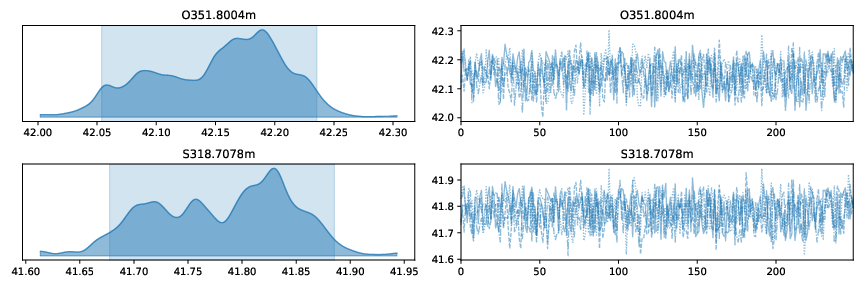

In [10]:
WImage(filename=output_directory+'Plots/Trace_observables_predict_combined.pdf') 

For [SIII] the observed value is $41.74$, we find: 

In [11]:
trace = az.from_netcdf(output_directory+'trace_post-process.netCDF')
float(trace.posterior['S318.7078m'].mean().data)

41.78163146972656

### Secondary parameters <a class="anchor" id="app7b"></a>

Now we will deduce secondary parameters in the list of available parameters in the post-processing table. For the SFGX context:
- extensive_secondary_parameters ['Q0', 'MH2_total', 'MH2_CO', 'MH2_C', 'MH2_C+', 'MHI', 'MHII', 'Mdust', 'CII_H+', 'CII_H', 'CII_H2']

We'll use the same galaxy and calculate M(H+) and Mdust. We should use two sectors because we're also modeling the PDR lines in order to get to the total dust mass. The test for number of sectors suggests that the most likely number of sectors given the data is 2. 

In [12]:
params = get_params()
params['context'].value = 'Contexts/mgris_sfgx'
output_directory = './Runs/ISM_applications/PP_params/'
params['output'].value = output_directory
params['USE configuration'].value = '1C2S'
params['select'].value = ['Z_dust [0,0]'] 
params['BEGIN observations'].value = '''O388.3323m 42.242 0.007 0.007
N357.3238m 41.458 0.012 0.013
N2121.767m 40.552 0.033 0.036
Ne315.5509m 42.088 0.075 0.09
Ne212.8101m 41.548 0.055 0.063
S410.5076m 41.732 0.008 0.008
S318.7078m 41.738 0.054 0.061
S333.4704m 41.843 0.019 0.019
Ar26.98337m 40.603 0.12 0.167
Ar38.98898m 41.052 0.058 0.067
Ar321.8253m <39.926 nan nan
H112.3684m 40.372 0.074 0.089
N2205.244m 40.376 0.083 0.102
O163.1679m 41.815 0.008 0.008
C2157.636m 41.823 0.005 0.005
O1145.495m 40.705 0.029 0.032'''
#params['BEGIN configuration'].value = '''
#cut (*) <= 1
#'''
#the grid line fluxes are in log [erg s-1] so we could apply a log factor if the unit is not the same
#we add a minimum 10% uncertainty
params['BEGIN observations'].extras = {'delta_add': 0.04, 'scale': 'log', 'delta_ref': 0.2}
params['use_scaling'].value = "'all'"
params['secondary_parameters'].value = "['MHII', 'Mdust']"
make_input(params, inputfile)

This is a long run, we'll go ahead with a small number of samples but a larger number will produce a much better posterior

In [13]:
if rcParams['inference_backend']=='gpu':
    nsamples_per_job = 150
else:
    nsamples_per_job = 100
    
closelogfiles() #in case run was interrupted
mgris_search.main(args=mgris_search.args(inputfile=inputfile, order=0, nsamples_per_job=nsamples_per_job))







       ┍ M U L ┑
       ┝ T I G ┥
       ┕ R I S ┙






     ┍           ┑
     ┝ INFERENCE ┥
     ┕           ┙






Thanks for using MULTIGRIS.
Please make sure to check the README file, the notebooks, and the publication (https://ui.adsabs.harvard.edu/abs/2022A%26A...667A..34L/abstract).







▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
▓ READING INPUT PARAMETERS ▓
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓


-- Using pre-defined configuration 1C2S

    ┍========================================┑
    ┝========= MULTIGRIS summary ============┥
    ┝========================================┙
    ┝ git version & date:
    ┝ - 1a38371 (2024-09-06 08:20:37 +0200)
    ┝ - 1a38371
    ┝ git submodules:
    ┝ - 'Contexts/mgris_bond': 474a7c3, 'Contexts/mgris_loc': 78805da, 'Contexts/mgris_sfgx': dcd6f15 
    ┝========================================
    ┝ PyMC version  : 5.16.2
    ┝ Tensor library: pytensor
    ┝ - Compile directory:
    ┝   - /tmp/pytensor.NOBACKUP
    ┝ - Precision: float32
    ┕=============

[16  3  8  5  5  8  4  4 17]
-> [16  1  8  5  5  8  4  4 17]
[16  1  8  5  5  8  4  4 17]
-> [16  1  1  5  5  8  4  4 17]


u 0: single value (nearest neighbor grid interpolation)


[16  1  1  5  5  8  4  4 17]
-> [16  1  1  1  5  8  4  4 17]
[16  1  1  1  5  8  4  4 17]


Z 0: single value (nearest neighbor grid interpolation)


-> [16  1  1  1  1  8  4  4 17]
[16  1  1  1  1  8  4  4 17]


Lx 0: single value (nearest neighbor grid interpolation)


-> [16  1  1  1  1  1  4  4 17]
[16  1  1  1  1  1  4  4 17]


Tx 0: single value (nearest neighbor grid interpolation)


-> [16  1  1  1  1  1  1  4 17]
[16  1  1  1  1  1  1  4 17]


cut 0: single value (nearest neighbor grid interpolation)


-> [16  1  1  1  1  1  1  1 17]
[16  1  1  1  1  1  1  1 17]


lum 1: single value (nearest neighbor grid interpolation)
age 1: single value (nearest neighbor grid interpolation)
n 1: single value (nearest neighbor grid interpolation)


-> [16  1  1  1  1  1  1  1  1]
[16  3  8  5  5  8  4  4 17]
-> [16  1  8  5  5  8  4  4 17]
[16  1  8  5  5  8  4  4 17]
-> [16  1  1  5  5  8  4  4 17]


u 1: single value (nearest neighbor grid interpolation)


[16  1  1  5  5  8  4  4 17]
-> [16  1  1  1  5  8  4  4 17]
[16  1  1  1  5  8  4  4 17]
-> [16  1  1  1  1  8  4  4 17]


Z 1: single value (nearest neighbor grid interpolation)


[16  1  1  1  1  8  4  4 17]


Lx 1: single value (nearest neighbor grid interpolation)


-> [16  1  1  1  1  1  4  4 17]
[16  1  1  1  1  1  4  4 17]


Tx 1: single value (nearest neighbor grid interpolation)


-> [16  1  1  1  1  1  1  4 17]
[16  1  1  1  1  1  1  4 17]


cut 1: single value (nearest neighbor grid interpolation)


-> [16  1  1  1  1  1  1  1 17]
[16  1  1  1  1  1  1  1 17]
-> [16  1  1  1  1  1  1  1  1]



Calculating prior predictive sample...
--------------------------------------
Sampling: [idx_Lx_0, idx_Tx_0, idx_Z_0, idx_age_0, idx_cut_0, idx_cut_1, idx_lum_0, idx_n_0, idx_n_1, idx_u_0, idx_u_1, scale, w]
Sampling: [idx_Lx_0, idx_Tx_0, idx_Z_0, idx_age_0, idx_cut_0, idx_cut_1, idx_lum_0, idx_n_0, idx_n_1, idx_u_0, idx_u_1, scale, w]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
idx_Lx_0         1.523  0.823   0.210    2.966      0.038    0.027     481.0   
idx_Lx_1         1.523  0.823   0.210    2.966      0.038    0.027     481.0   
idx_Tx_0         1.480  0.786   0.093    2.738      0.039    0.028     468.0   
idx_Tx_1         1.480  0.786   0.093    2.738      0.039    0.028     468.0   
idx_Z_0          3.288  1.882   0.076    6.369      0.085    0.060     484.0   
idx_Z_1          3.288  1.882   0.076    6.369      0.085    0.060     484.0   


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details

✨
✨✨
✨✨✨✨✨
✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨
✨✨✨✨✨
✨✨
✨
✨✨
✨✨✨✨
✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨ INFERENCE END
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨
✨✨✨✨
✨✨
✨
Inference ended     : 2024-09-06 18:50:53.331190
Time used           : 19.5 min.
Sampling time used  :  18.39 min.
Garbage collection thresholds : (700, 10, 10)
Garbage collector: collected 1702738 objects.

▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
▓ RESULTS AND VERIFICATIONS ▓
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓


                          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
idx_Lx_0               

In [14]:
closelogfiles() #in case run was interrupted
mgris_process.main(args=mgris_process.args(inputfile=inputfile))







       ┍ M U L ┑
       ┝ T I G ┥
       ┕ R I S ┙






     ┍            ┑
     ┝ PROCESSING ┥
     ┕            ┙






Thanks for using MULTIGRIS.
Please make sure to check the README file, the notebooks, and the publication (https://ui.adsabs.harvard.edu/abs/2022A%26A...667A..34L/abstract).

▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
▓ READING INFERENCE DATA ▓
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓


-- Using pre-defined configuration 1C2S







    ┍========================================┑
    ┝=========== System summary =============┥
    ┝========================================┙
    ┝ Date/time:
    ┝ - 06/09/2024 18:50:56
    ┕========================================┙
   







    ┍========================================┑
    ┝============= Run summary ==============┥
    ┝========================================┙
    ┝ - input file         : ./Runs/ISM_applications/input.txt
    ┝ - output directory   : ./Runs/ISM_applications/PP_params/
    ┕========================================┙
    
Li

In [15]:
%cat $output_directory/results.txt


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
idx_Lx_0   1.709  0.400   1.043    2.437      0.066    0.048      44.0      87.0   1.22
idx_Lx_1   1.709  0.400   1.043    2.437      0.066    0.048      44.0      87.0   1.22
idx_Tx_0   1.993  0.219   1.622    2.418      0.020    0.014     171.0     157.0   1.11
idx_Tx_1   1.993  0.219   1.622    2.418      0.020    0.014     171.0     157.0   1.11
idx_Z_0    5.195  0.369   4.505    5.722      0.132    0.098       9.0      30.0   1.48
idx_Z_1    5.195  0.369   4.505    5.722      0.132    0.098       9.0      30.0   1.48
idx_age_0  3.370  1.429   0.720    5.158      0.348    0.269      19.0      25.0   1.18
idx_age_1  3.370  1.429   0.720    5.158      0.348    0.269      19.0      25.0   1.18
idx_cut_0  5.977  1.597   3.519    8.895      0.410    0.296      16.0     153.0   1.24
idx_cut_1  5.421  0.590   4.551    6.373      0.161    0.116      13.0      64.0   1.26
idx_lum_0  1.145  0.180   0.827

In [16]:
closelogfiles() #in case run was interrupted
mgris_post_process.main(args=mgris_post_process.args(inputfile=inputfile))







          ┍ M U L ┑
          ┝ T I G ┥
          ┕ R I S ┙






     ┍                 ┑
     ┝ POST-PROCESSING ┥
     ┕                 ┙






Thanks for using MULTIGRIS.
Please make sure to check the README file, the notebooks, and the publication (https://ui.adsabs.harvard.edu/abs/2022A%26A...667A..34L/abstract).







    ┍========================================┑
    ┝=========== System summary =============┥
    ┝========================================┙
    ┝ Date/time:
    ┝ - 06/09/2024 18:51:35
    ┕========================================┙
   
-- Using pre-defined configuration 1C2S

    Run summary
    - input file         : ./Runs/ISM_applications/input.txt
    - output directory   : ./Runs/ISM_applications/PP_params/
    
Loading multi-trace...
Reading post-processing file ['post_processing_all_cutAv.fth', '#model_number']
Reading Feather file... /local/home/vleboute/work/MULTIGRIS/mgris/Contexts/mgris_sfgx/Grids/model_grid.fth (run pre-processing script if the 

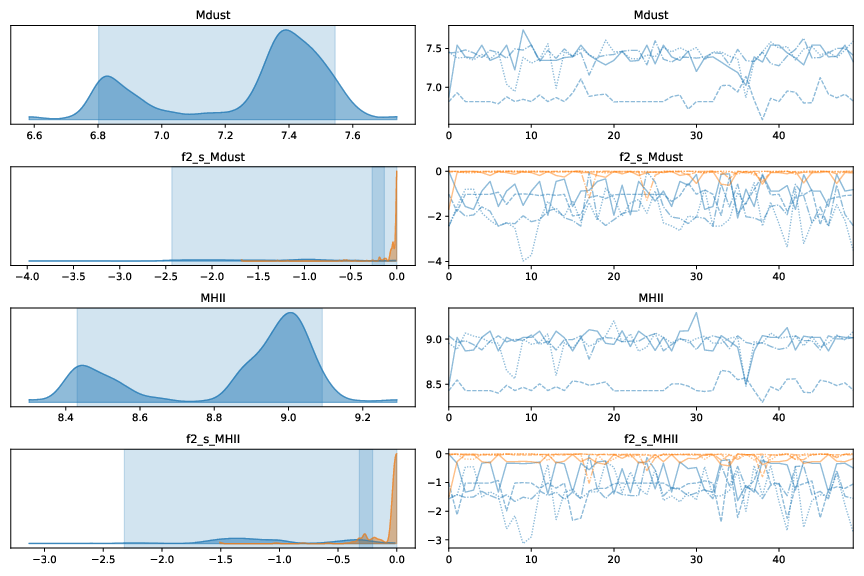

In [17]:
WImage(filename=output_directory+'Plots/Trace_params_predict_combined.pdf') 

The ionized gas mass is

In [18]:
trace = az.from_netcdf(output_directory+'trace_post-process.netCDF')
float(trace.posterior['MHII'].mean().data)

8.844308853149414

For reference Haro 11 should have a total mass of $10^{11}$ M$_\odot$ (Ostlin et al. [2015](https://ui.adsabs.harvard.edu/abs/2015A%26A...583A..55O/abstract)), the ionized gas mass should be about $6\times10^8$ M$_\odot$ (Cormier et al. [2012](https://ui.adsabs.harvard.edu/abs/2012A&A...548A..20C/abstract)) or $10^9$ M$_\odot$ (Bergvall & Ostlin ([2002](https://ui.adsabs.harvard.edu/abs/2002A%26A...390..891B/abstract)) and Mdust 1e6.5 (Rémy-Ruyer+ [2015](https://ui.adsabs.harvard.edu/abs/2015A&A...573C...1R/abstract))